In [1]:
import sys
sys.path.append('classical')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm 
from binary_functions import Int2Bas,Bas2Int,Opp2Str,Str2Opp
from Pmn import PPmunu

In [3]:
t_hubbard = 1
U_hubbard = 2
beta = 2.0
sigma = np.zeros([2, 2, 4], dtype=complex)
sigma[0, 0, 0] = 1.
sigma[1, 1, 0] = 1.
sigma[0, 1, 1] = 1.
sigma[1, 0, 1] = 1.
sigma[0, 1, 2] = -1j
sigma[1, 0, 2] = 1j
sigma[0, 0, 3] = 1.
sigma[1, 1, 3] = -1.
N = 40 # Number of imaginary time steps

# Defining the Hamiltonian
Hamiltonian = -t_hubbard * (np.kron(sigma[:, :, 1], sigma[:, :, 0]) + np.kron(sigma[:, :, 0], sigma[:, :, 1])) \
             + U_hubbard / 2 * (np.kron(sigma[: ,:, 0], sigma[: ,:, 0]) + np.kron(sigma[:, :, 3], sigma[:, :, 3]))
w, v = np.linalg.eigh(Hamiltonian)
print('The exact solution is ', w[0])

The exact solution is  -1.2360679774997898


In [4]:
# Classical trajectory

# List to store energy values
energy_classical_list = []
energy_qite_list = []

# Initialize into |00> state
psi = np.array([1,0,0,0],dtype=complex)
psi = psi/np.linalg.norm(psi)

db = beta/N
expmH = expm(-db * Hamiltonian)
phi = psi

# Store the energy for initial wavefunction
e = np.matmul(Hamiltonian, phi)
e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
energy_classical_list.append(e)

# Perform imaginary time evolution
for i in range(0,N):

    # Perform imaginary time evolution
    phi = np.matmul(expmH, phi)

    # Require normalization because imaginary time evolution is non-unitary
    phi = phi / np.linalg.norm(phi)

    # Store the energy values at each step
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_classical_list.append(e)
print('Final energy at beta', beta, 'is ', e)

Final energy at beta 2.0 is  -1.2360397973284416


## QITE Approximation

In [5]:
# First populate the Lie algebra rules
index = np.zeros([4**2,4**2],dtype=int)
coeff = np.zeros([4**2,4**2],dtype=complex)

row = 0
for i in range(4**2):
    column = 0
    for j in range(4**2):
        Pnu = Opp2Str(Int2Bas(column,4,2))
        Pmu = Opp2Str(Int2Bas(row,4,2))
        A = Pmu[0] + Pnu[0]
        B = Pmu[1] + Pnu[1]
        A,intA = PPmunu(A)
        B,intB = PPmunu(B)
        index[i,j] = Bas2Int(Str2Opp(A+B),4)
        coeff[i,j] = intA*intB
        column += 1
    row += 1
    
print(index)
print(coeff)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 1  0  3  2  5  4  7  6  9  8 11 10 13 12 15 14]
 [ 2  3  0  1  6  7  4  5 10 11  8  9 14 15 12 13]
 [ 3  2  1  0  7  6  5  4 11 10  9  8 15 14 13 12]
 [ 4  5  6  7  0  1  2  3 12 13 14 15  8  9 10 11]
 [ 5  4  7  6  1  0  3  2 13 12 15 14  9  8 11 10]
 [ 6  7  4  5  2  3  0  1 14 15 12 13 10 11  8  9]
 [ 7  6  5  4  3  2  1  0 15 14 13 12 11 10  9  8]
 [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
 [ 9  8 11 10 13 12 15 14  1  0  3  2  5  4  7  6]
 [10 11  8  9 14 15 12 13  2  3  0  1  6  7  4  5]
 [11 10  9  8 15 14 13 12  3  2  1  0  7  6  5  4]
 [12 13 14 15  8  9 10 11  4  5  6  7  0  1  2  3]
 [13 12 15 14  9  8 11 10  5  4  7  6  1  0  3  2]
 [14 15 12 13 10 11  8  9  6  7  4  5  2  3  0  1]
 [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]]
[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j
   1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  0.+1.j  0.-1.j  1.+0.j  1.+0.j 

In [6]:
# QITE trajectory

phi = psi
print(phi)
# Store the energy for initial wavefunction
e = np.matmul(Hamiltonian, phi)
e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
energy_qite_list.append(e)

debug_Pmu_expectation_list = []

print('We start QITE now')
for i in range(0,N):

    # First construct Pmu_expectation matrices
    Pmu_expectation = np.zeros([16], dtype=complex)
    for Pmu in range(2**4):
        ops = Int2Bas(Pmu, 4, 2)
#         print("ops: ", ops)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        Pmu_expectation[Pmu] = np.matmul(np.transpose(np.conj(phi)), np.matmul(operator, phi))
        
    debug_Pmu_expectation_list.append(Pmu_expectation.real.tolist())

    # Now construct S matrix
    S = np.zeros([16, 16], dtype=complex)
    for i in range(16):
        for j in range(16):
            S[i,j] = Pmu_expectation[index[i, j]]*coeff[i, j]

    # Now construct b vector
    b = np.zeros([16], dtype=complex)
    c = 1

    # We will hardcode in the QITE step

    c -= 2 * db * (-t_hubbard) * Pmu_expectation[1]
    c -= 2 * db * (-t_hubbard) * Pmu_expectation[4]
    c -= 2 * db * (U_hubbard / 2) * Pmu_expectation[0]
    c -= 2 * db * (U_hubbard / 2) * Pmu_expectation[15]
    c = np.sqrt(c)
    
    for i in range(16):
        b[i] += (Pmu_expectation[i] / c - Pmu_expectation[i]) / db
        b[i] -= (-t_hubbard) * coeff[i, 1] * Pmu_expectation[index[i, 1]] / c
        b[i] -= (-t_hubbard) * coeff[i, 4] * Pmu_expectation[index[i, 4]] / c
        b[i] -= (U_hubbard / 2) * coeff[i, 0] * Pmu_expectation[index[i, 0]] / c
        b[i] -= (U_hubbard / 2) * coeff[i, 15] * Pmu_expectation[index[i, 15]] / c
        b[i] = 1j * b[i] - 1j * np.conj(b[i])

    # Obtain x 
    dalpha = np.eye(16) * 0.01
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]

    # Classical evolution
    U = np.eye(4)
    for i in range(len(x)):
        ops = Int2Bas(i, 4, 2)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        U = np.matmul(expm(1j * db * x[i] * operator), U)
    phi = np.matmul(U, phi)
    
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_qite_list.append(e)
print('Final energy from QITE is ', e)

print(debug_Pmu_expectation_list)


[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
We start QITE now
Final energy from QITE is  -1.236045246243432
[[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], [0.9999999999999998, 0.11086108265002184, -2.3701636405366485e-17, 0.9937924042757851, 0.11086108265002173, 0.003106211876230596, 2.0536618701879933e-16, 0.11120705306559495, -6.099097543193006e-16, 1.3976850585736573e-16, 0.009299331019978764, -6.290893652905017e-16, 0.993792404275785, 0.11120705306559506, -4.105183473401435e-17, 0.9875944571037903], [1.0, 0.22855138352124413, 2.928964092544699e-16, 0.9733007472581157, 0.22891344515533618, 0.03224095094282042, 1.8979905581836617e-16, 0.22762207039851495, -3.803684151432205e-16, 3.249036198626321e-17, 0.021211328985208344, -4.0481511550415014e-16, 0.9732156565478156, 0.2272579513880564, 2.6460422348989474e-16, 0.9465476523440426], [0.9999999999999998, 0.3486496850725175, 4.988857016394855e-16, 0.9364943964684751, 0.34976673338301983, 0.08901950673898747, 9.88732

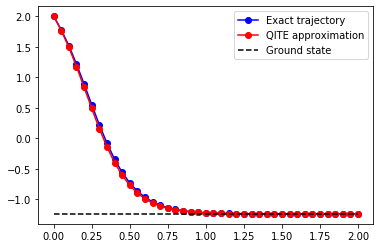

In [7]:
plt.figure()
beta_list = np.asarray(range(0, N+1)) * db
plt.plot(beta_list, energy_classical_list, '-bo', label='Exact trajectory')
plt.plot(beta_list, energy_qite_list, '-ro', label='QITE approximation')
plt.plot([beta_list[0], beta_list[-1]], [w[0], w[0]], '--k', label='Ground state')
plt.legend()
plt.show()